# 1. Imports

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as pl
%matplotlib inline
import itertools

# 2. Functions

## 2.1 Define epoch function

In [2]:
def datime2epoch(dt):
    """
    Thi is an example script.

    It seems that it has to have THIS docstring with a summary line, a blank line
    and sume more text like here. Wow.
    """
    # cast dt into string in case it isn't 
    dt = str(dt)
    if dt != 'summary':
        if str(dt) != 'nan':
            if '_' in dt:
                YYYY, mm, dd = dt.split('_')
            else:
                YYYY = dt[0:4]
                mm = dt[4:6]
                dd = dt[6:8]
            return (
                date(
                    int(YYYY),
                    int(mm),
                    int(dd)
                ) - date(1970 ,1, 1)
            ).total_seconds()
        else:
            return -1
    else:
        return -1

## 2.2 Get latest delegation file

In [3]:
def get_latest_delegation_file(
    rir, path_to_files = '../../data/processed/delegation_files/%s/asns'):
    path_to_rir_delegation_files = path_to_files % rir
    delegation_file_a = np.array(glob.glob(path_to_rir_delegation_files + '/*'))
    delegation_file_a = np.sort(delegation_file_a)
    return delegation_file_a[-1]

# 3. Load delegation files

## 3.1 Load LACNIC data

In [4]:
lacnic_latest_df = pd.read_csv(
    get_latest_delegation_file('lacnic'),
    names=[
        'rir',
        'cc',
        'resource',
        'asn',
        'void',
        'allocation_date',
        'status',
        'hash'
    ],
    sep='|'
)

In [5]:
# sort values
lacnic_latest_df = lacnic_latest_df.sort_values('allocation_date', ascending=True)
# Remove rows that do not contains ASNs
lacnic_latest_df = lacnic_latest_df.loc[
    lacnic_latest_df['asn'] != '*'
]
# Adds epoch column
lacnic_latest_df['epoch'] = lacnic_latest_df['allocation_date'].apply(datime2epoch)
# cast ASN to int to then use with BGP table dump data frame
lacnic_latest_df['asn'] = lacnic_latest_df['asn'].values.astype(int)

## 3.2 Load RIPE data

In [6]:
ripe_latest_df = pd.read_csv(
    get_latest_delegation_file('ripe'),
    names=[
        'rir',
        'cc',
        'resource',
        'asn',
        'void',
        'allocation_date',
        'status',
        'hash'
    ],
    sep='|'
)

In [7]:
# sort values
ripe_latest_df = ripe_latest_df.sort_values('allocation_date', ascending=True)
# Remove rows that do not contains ASNs
ripe_latest_df = ripe_latest_df.loc[
    ripe_latest_df['asn'] != '*'
]
# Adds epoch column
ripe_latest_df['epoch'] = ripe_latest_df['allocation_date'].apply(datime2epoch)
# cast ASN to int to then use with BGP table dump data frame
ripe_latest_df['asn'] = ripe_latest_df['asn'].values.astype(int)

## 3.3 Load APNIC data

In [8]:
apnic_latest_df = pd.read_csv(
    get_latest_delegation_file('apnic'),
    names=[
        'rir',
        'cc',
        'resource',
        'asn',
        'void',
        'allocation_date',
        'status',
        'hash'
    ],
    sep='|'
)

In [9]:
# sort values
apnic_latest_df = apnic_latest_df.sort_values('allocation_date', ascending=True)
# Remove rows that do not contains ASNs
apnic_latest_df = apnic_latest_df.loc[
    apnic_latest_df['asn'] != '*'
]
# Adds epoch column
apnic_latest_df['epoch'] = apnic_latest_df['allocation_date'].apply(datime2epoch)
# cast ASN to int to then use with BGP table dump data frame
apnic_latest_df['asn'] = apnic_latest_df['asn'].values.astype(int)

## 3.4 Load AFRINIC data

In [10]:
afrinic_latest_df = pd.read_csv(
    get_latest_delegation_file('afrinic'),
    names=[
        'rir',
        'cc',
        'resource',
        'asn',
        'void',
        'allocation_date',
        'status',
        'hash'
    ],
    sep='|'
)

In [11]:
# sort values
afrinic_latest_df = afrinic_latest_df.sort_values('allocation_date', ascending=True)
# Remove rows that do not contains ASNs
afrinic_latest_df = afrinic_latest_df.loc[
    afrinic_latest_df['asn'] != '*'
]
# Adds epoch column
afrinic_latest_df['epoch'] = afrinic_latest_df['allocation_date'].apply(datime2epoch)
# cast ASN to int to then use with BGP table dump data frame
afrinic_latest_df['asn'] = afrinic_latest_df['asn'].values.astype(int)

## 3.5 Turn into a dictt

In [12]:
rir_latest_dict = {
    'lacnic': lacnic_latest_df,
    'apnic': apnic_latest_df,
    'ripe': ripe_latest_df,
    'afrinic': afrinic_latest_df,
}

# 4. Get month-to-month active ASes from CAIDA's AS-REL files

In [13]:
path_to_asrel_files = '../../data/raw/asrel'
asrel_file_a = np.array(glob.glob(path_to_asrel_files + '/*'))
asrel_file_a = np.sort(asrel_file_a)

In [14]:
active_ases_dict={}
for file_name in asrel_file_a:
    # get date
    date_str = str(file_name.split('/')[-1].split('.')[0])
    # open AS-REL file
    try:
        p2c_df = pd.read_csv(
            file_name,
            comment='#',
            header=None,
            sep='|',
            compression='bz2'
        )
        # set column names
        p2c_df.columns = ['provider', 'customer', 'type']
        active_ases_dict[date_str] = list(
            set().union(
                p2c_df['provider'].values.tolist(),
                p2c_df['customer'].values.tolist()
            )
        )
    except:
        print('No data available for %s' % date_str)

No data available for 20140101
No data available for 20140201
No data available for 20140301
No data available for 20140501
No data available for 20150301
No data available for 20150401


# 5. Get visible ASes from RIBs

In [15]:
def get_visible_ases(bgp_table_dump_df, ixp_asn):
    """
    Thi is an example script.

    It seems that it has to have THIS docstring with a summary line, a blank line
    and sume more text like here. Wow.
    """
    # create set of IXP members
    members_set = set()
    # Loop
    for as_path_str in bgp_table_dump_df.drop_duplicates(
        'as-path')['as-path'].values:
        as_path_list = as_path_str.split(',')
        # if AS-PATH contains more than one AS
        # If not, the IXP member is directly annoucing 
        # its routes to the monitor
        if len(as_path_list) > 1:
            # Removes path through HE (AS6939 from the path)
            if int(as_path_list[0]) != 6939 and int(as_path_list[1]) != 6939:
            # Checks if the route server is the once announcing the path
            # If so, remove IXP ASN from path
            # If not, it is direct member
                if int(as_path_list[0]) == ixp_asn:
                    init_val = 1
                else:
                    init_val = 0
                for i in range(1, len(as_path_list)):
                        members_set.add(int(as_path_list[i]))
        else:
            members_set.add(int(as_path_str))
    return members_set

In [16]:
ixp_under_analysis_list = [
    # Frankfurt (DE-CIX)
    'fra',
    # Paris (Frace-IX)
    'cdg',
    # Bangkok (BNKIX)
    'bkk',
    # Johanesburg (JINX)
    'jnb',
    # IX.br Sao Paulo
    'saopaulo',
    # CABASE-BUE
    'eze',
    # PIT Chile
    'scl'
]

In [17]:
ixp_rir_dict = {
    # Frankfurt (DE-CIX)
    'fra': 'ripe',
    # Paris (Frace-IX)
    'cdg': 'ripe',
    # Bangkok (BNKIX)
    'bkk': 'apnic',
    # Johanesburg (JINX)
    'jnb': 'afrinic',
    # IX.br Sao Paulo
    'saopaulo': 'lacnic',
    # CABASE-BUE
    'eze': 'lacnic',
    # PIT Chile
    'scl': 'lacnic'
}

In [18]:
ixp_cc_dict = {
    # Frankfurt (DE-CIX)
    'fra': 'DE',
    # Paris (Frace-IX)
    'cdg': 'FR',
    # Bangkok (BNKIX)
    'bkk': 'TH',
    # Johanesburg (JINX)
    'jnb': 'ZA',
    # IX.br Sao Paulo
    'saopaulo': 'BR',
    # CABASE-BUE
    'eze': 'AR',
    # PIT Chile
    'scl': 'CL'
}

In [19]:
ixp_asn_dict = {
    'eze': 11058,
    'scl': 61522,
    # We do not care about this now
    'fra': None,
    # We do not care about this now
    'cdg': None,
    # We do not care about this now
    'bkk': None,
    # We do not care about this now
    'jnb': None,
    # We do not care about this now
    'saopaulo': None,
}

In [20]:
path_to_ixp_bgp_dumps_dirs = '../../data/processed/ribs/v4'

**MAIN BLOCK OF THIS NOTEBOOK**

In [21]:
output_list = []
inactive_list = []
for ixp in ixp_under_analysis_list:
    # get all BGP table dumps
    ixp_bgp_table_dump_files_a = np.array(glob.glob(path_to_ixp_bgp_dumps_dirs + '/' + ixp + '/*'))
    # sort BGP table dumps by ASCENDING DATE
    ixp_bgp_table_dump_files_a = np.sort(ixp_bgp_table_dump_files_a)
    # Loop over each BGP table dump (month-to-month analysis)
    for bgp_table_dump_file in ixp_bgp_table_dump_files_a:
        bgp_table_dump_df = pd.read_csv(
            bgp_table_dump_file,
            header='infer',
            sep=','
        )
        # Remove NaN path if exists
        bgp_table_dump_df = bgp_table_dump_df.loc[
            bgp_table_dump_df['as-path'].notnull()
        ]
        # find visible ASes from BGP table dump
        members_set = get_visible_ases(bgp_table_dump_df, ixp_asn_dict[ixp])
        # get snapshot's date --> DATETIME
        date_datetime = datime2epoch(bgp_table_dump_file.split('/')[-1])
        # get snapshot's date --> STR WITHOUT _
        date_no_spaces_str = bgp_table_dump_file.split('/')[-1].replace('_','')
        # get snapshot's date --> STR 
        date_str = bgp_table_dump_file.split('/')[-1]
        # select RIR delegation file according to the IXP's country
        rir_latest_df = rir_latest_dict[ixp_rir_dict[ixp]]
        # get COUNTRY CODE of IXP's country
        cc = ixp_cc_dict[ixp]
        # if Brazil, day has to be changed from 10 to 01
        if cc == 'BR':
            date_no_spaces_str = date_no_spaces_str[:-2] + '01'
        # check if:
        #    i) CAIDA's AS-REL files exists for that date
        #    ii) RIB DOES contain information 
        if (date_no_spaces_str in active_ases_dict.keys()) and \
        (len(members_set) > 0):
            # compute the total number of active ASes in that country
            total_ases_active_cnt = rir_latest_df.loc[
                (rir_latest_df['epoch'] <= date_datetime)  &  
                (rir_latest_df['epoch'] > 0) & 
                (rir_latest_df['cc'] == cc ) & 
                (rir_latest_df['asn'].isin(active_ases_dict[date_no_spaces_str]))
            ]['asn'].values.size
            # compute the total number of INACTIVE ASes in that country
            total_ases_inactive_cnt = rir_latest_df.loc[
                (rir_latest_df['epoch'] <= date_datetime)  &  
                (rir_latest_df['epoch'] > 0) & 
                (rir_latest_df['cc'] == cc ) & 
                (~rir_latest_df['asn'].isin(active_ases_dict[date_no_spaces_str]))
            ]['asn'].values.size
            # compute the number of country's active ASes visible at the IXP
            delegated_and_visible_ases_at_ixp = rir_latest_df.loc[
                (rir_latest_df['epoch'] <= date_datetime)  &  
                (rir_latest_df['epoch'] > 0) & 
                (rir_latest_df['cc'] == cc ) & 
                (rir_latest_df['asn'].isin(active_ases_dict[date_no_spaces_str])) &
                (rir_latest_df['asn'].isin(list(members_set))) 
            ]['asn'].values.size
            # checks if total_ases_active_cnt is not ZERO
            if total_ases_active_cnt > 0:
                # Appends results to the list
                output_list.append(
                    (
                        ixp,
                        date_str,
                        delegated_and_visible_ases_at_ixp,
                        total_ases_active_cnt,
                        delegated_and_visible_ases_at_ixp / float(total_ases_active_cnt)
                    )
                )
                inactive_list.append(
                    (
                        cc,
                        date_str,
                        total_ases_active_cnt,
                        total_ases_inactive_cnt,
                        total_ases_inactive_cnt / float(total_ases_inactive_cnt + total_ases_active_cnt)
                    )
                )
            else:
                print('TOTAL = 0 (%s, %s)' % (ixp, date_str))

In [22]:
active_ases_frac_df = pd.DataFrame(
    output_list,
    columns=[
        'iata_code',
        'date',
        'delegated_and_visible_cnt',
        'total_active_cnt',
        'frac'
    ]
)

In [23]:
active_ases_frac_df['epoch'] = active_ases_frac_df['date'].apply(datime2epoch)

In [24]:
active_ases_frac_df.loc[
    (active_ases_frac_df['epoch'] == active_ases_frac_df['epoch'].max()) |
    (active_ases_frac_df['epoch'] == active_ases_frac_df.tail()['epoch'].values[-2])
]

,iata_code,date,delegated_and_visible_cnt,total_active_cnt,frac,epoch
94,fra,2019_06_01,1666,1877,0.887587,1.559347e+09
197,cdg,2019_06_01,669,1094,0.611517,1.559347e+09
215,bkk,2019_06_01,230,370,0.621622,1.559347e+09
281,jnb,2019_06_01,347,399,0.869674,1.559347e+09
375,saopaulo,2019_07_10,5139,6458,0.795757,1.562717e+09
471,eze,2019_06_01,667,777,0.858430,1.559347e+09
498,scl,2019_06_01,227,232,0.978448,1.559347e+09


### INACTIVE fraction

In [25]:
inactive_ases_frac_df = pd.DataFrame(
    inactive_list,
    columns=[
        'cc',
        'date',
        'total_active_cnt',
        'total_inactive_cnt',
        'inactive_frac'
    ]
)

In [26]:
inactive_ases_frac_df['epoch'] = inactive_ases_frac_df['date'].apply(datime2epoch)

In [27]:
inactive_ases_frac_df.head()

,cc,date,total_active_cnt,total_inactive_cnt,inactive_frac,epoch
0,DE,2010_07_01,1009,204,0.168178,1.277942e+09
1,DE,2010_08_01,1016,202,0.165846,1.280621e+09
2,DE,2010_09_01,1025,204,0.165989,1.283299e+09
3,DE,2010_10_01,1032,204,0.165049,1.285891e+09
4,DE,2010_11_01,1041,200,0.161160,1.288570e+09


In [28]:
inactive_mean_df = inactive_ases_frac_df.groupby('cc')['inactive_frac'].mean().reset_index()
inactive_mean_df

,cc,inactive_frac
0,AR,0.260886
1,BR,0.124506
2,CL,0.267508
3,DE,0.200591
4,FR,0.185629
5,TH,0.256196
6,ZA,0.296575


In [29]:
inactive_std_df = inactive_ases_frac_df.groupby('cc')['inactive_frac'].std().reset_index()
inactive_std_df

,cc,inactive_frac
0,AR,0.034925
1,BR,0.077842
2,CL,0.015232
3,DE,0.033429
4,FR,0.027026
5,TH,0.010724
6,ZA,0.035839


# 6. Plot results

In [30]:
label_dict = {
    'scl': 'PIT Chile-SCL',
    'eze': 'CABASE-BUE',
    'asu': 'IX.py',
    'saopaulo': 'IX.br',
    'fra': 'DE-CIX-fra',
    'cdg': 'France-IX-Paris',
    'jnb': 'JINX',
    'bkk': 'BKNIX',
}

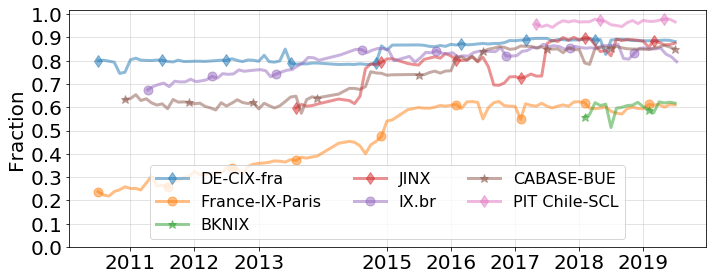

In [31]:
marker_iter = itertools.cycle(('d', 'o', '*')) 
fig, ax1 = pl.subplots(1,figsize=(10, 4))
ax1.yaxis.grid(True, linestyle='-', color='#bababa',alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='#bababa',alpha=0.5)
# plot frac for each AS
for iata_code in active_ases_frac_df.drop_duplicates('iata_code')['iata_code'].values:
    ax1.plot(
        active_ases_frac_df.loc[
            (active_ases_frac_df['frac'] > 0) &
            (active_ases_frac_df['iata_code'] == iata_code) 
        ]['epoch'].values,
        active_ases_frac_df.loc[
            (active_ases_frac_df['frac'] > 0) &
            (active_ases_frac_df['iata_code'] == iata_code) 
        ]['frac'].values,
        label=label_dict[iata_code],
        marker = next(marker_iter),
        markersize=9,
        markevery=12,
        alpha=0.5,
        linewidth=3
    )

#
ticks = []
xlabels = []
for index, row in active_ases_frac_df.drop_duplicates('date').iterrows():
    dt_datetime = str(row['date'])
    if dt_datetime[-5:] == '01_01':
        ticks.append(row['epoch'])
        xlabels.append(dt_datetime[0:4])

ax1.set_xticks(ticks, minor=False)
ax1.set_xticklabels(xlabels, rotation=0, minor=False, ha='center')
ax1.set_yticks(np.arange(0, 1.01, 0.1), minor=False)
ax1.set_ylabel('Fraction', fontsize=20)
ax1.set_xlabel('', fontsize=14)
ax1.tick_params(labelsize=20)

ax1.legend(loc='lower center', ncol=3, frameon=True, fontsize=16)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig('../../figures/4_3_1Total_vs_Delegated.pdf')